In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import math

In [2]:
import time
from gwpy.segments import Segment
from gwpy.segments import SegmentList

In [3]:
from IPython.display import Image

In [22]:
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

## Introduction of Blip glitches

### Short burts of energy are called noise transients, also known as glitches. One of the most common glitch that affects the data quality is known as Blip. The origin of thee short duration noise transients are not very well understood. We do know that they are not caused by environmental factors such as weather patterns, wind, seismic noise etc. They do not have seasonal, daily or hourly variations. The exact times of these glitches is unknown, but we do know they occur at a regular interval.  In this notebook, we will study blip gitches as a Poisson process. The blip glitch is shown in the time-frequency plane in the image below

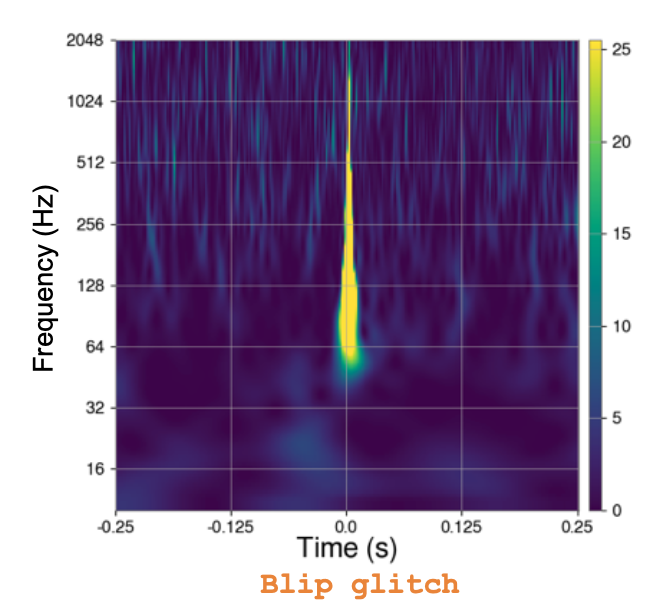

In [5]:
Image(filename='blip_glitch.png')

### Reading the blip data between Nov, 20, 2019 and March, 10, 2020 from LLO (Ligo Livingston Observatory)

In [6]:
dfblips = pd.read_csv('blips_nov20_mar10.csv')

In [7]:
dfblips.head()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1.264925e+09,39.789,24.655,1.920000e-22,1559.369,1.000,3080.907227,0.0,0.0,1.0,88EqbhD1hG,L1,Blip,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,5.657
1,1.259518e+09,269.285,22.520,7.970000e-23,2973.983,0.158,5876.407227,0.0,0.0,1.0,oo6HrSyexV,L1,Blip,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,5.657
2,1.267444e+09,269.285,13.185,4.660000e-23,368.161,0.047,664.763672,0.0,0.0,1.0,DFuF1n3qpn,L1,Blip,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,5.657
3,1.265959e+09,142.363,12.939,4.480000e-23,447.653,0.078,837.445374,0.0,0.0,1.0,pjGJhTdpzw,L1,Blip,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,5.657
4,1.258618e+09,93.079,10.065,3.810000e-23,106.521,0.188,103.595322,0.0,0.0,1.0,CqHHTeqGg6,L1,Blip,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,5.657


### Data Cleaning

In [8]:
dfblips['GPStime'].duplicated().sum()

54

In [9]:
dfblips.drop_duplicates(['GPStime'],inplace=True)
dfblips.sort_values(by='GPStime',inplace=True)
dfblips.drop(['chisq','chisqDof','id','imgUrl','Q-value'],axis=1,inplace=True)
dfblips = dfblips.reset_index(drop=True)

In [10]:
dfblips.head()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,confidence,ifo,label
0,1.258245e+09,49.208,8.066,5.810000e-23,53.546,0.055,60.305382,0.998,L1,Blip
1,1.258252e+09,411.865,23.146,1.030000e-22,1273.859,0.215,2489.856201,1.000,L1,Blip
2,1.258253e+09,269.285,7.897,3.100000e-23,347.233,0.006,438.436798,0.987,L1,Blip
3,1.258254e+09,217.741,9.046,3.530000e-23,262.852,0.020,390.349457,0.953,L1,Blip
4,1.258254e+09,49.208,8.653,5.610000e-23,53.546,0.063,60.305382,0.997,L1,Blip


In [11]:
# plt.figure(figsize=(12,8))
# plt.hist(np.diff(dfblips['GPStime']),bins=np.arange(0,10000,200))
# plt.xlabel('Waiting time (secs)',fontsize=14)
# plt.xticks(np.arange(0,10000,400),np.arange(0,100,4),fontsize=14)
# plt.title("Waiting time distribution of Blips",fontsize=18)
# plt.show()

### Now we will take all the active segments and for each active segments we will calculate the waiting time for the blips only within this active segment. This way we will get rid of the huge jumps of waiting time for triggers which lie in two different segments because of lock loss.

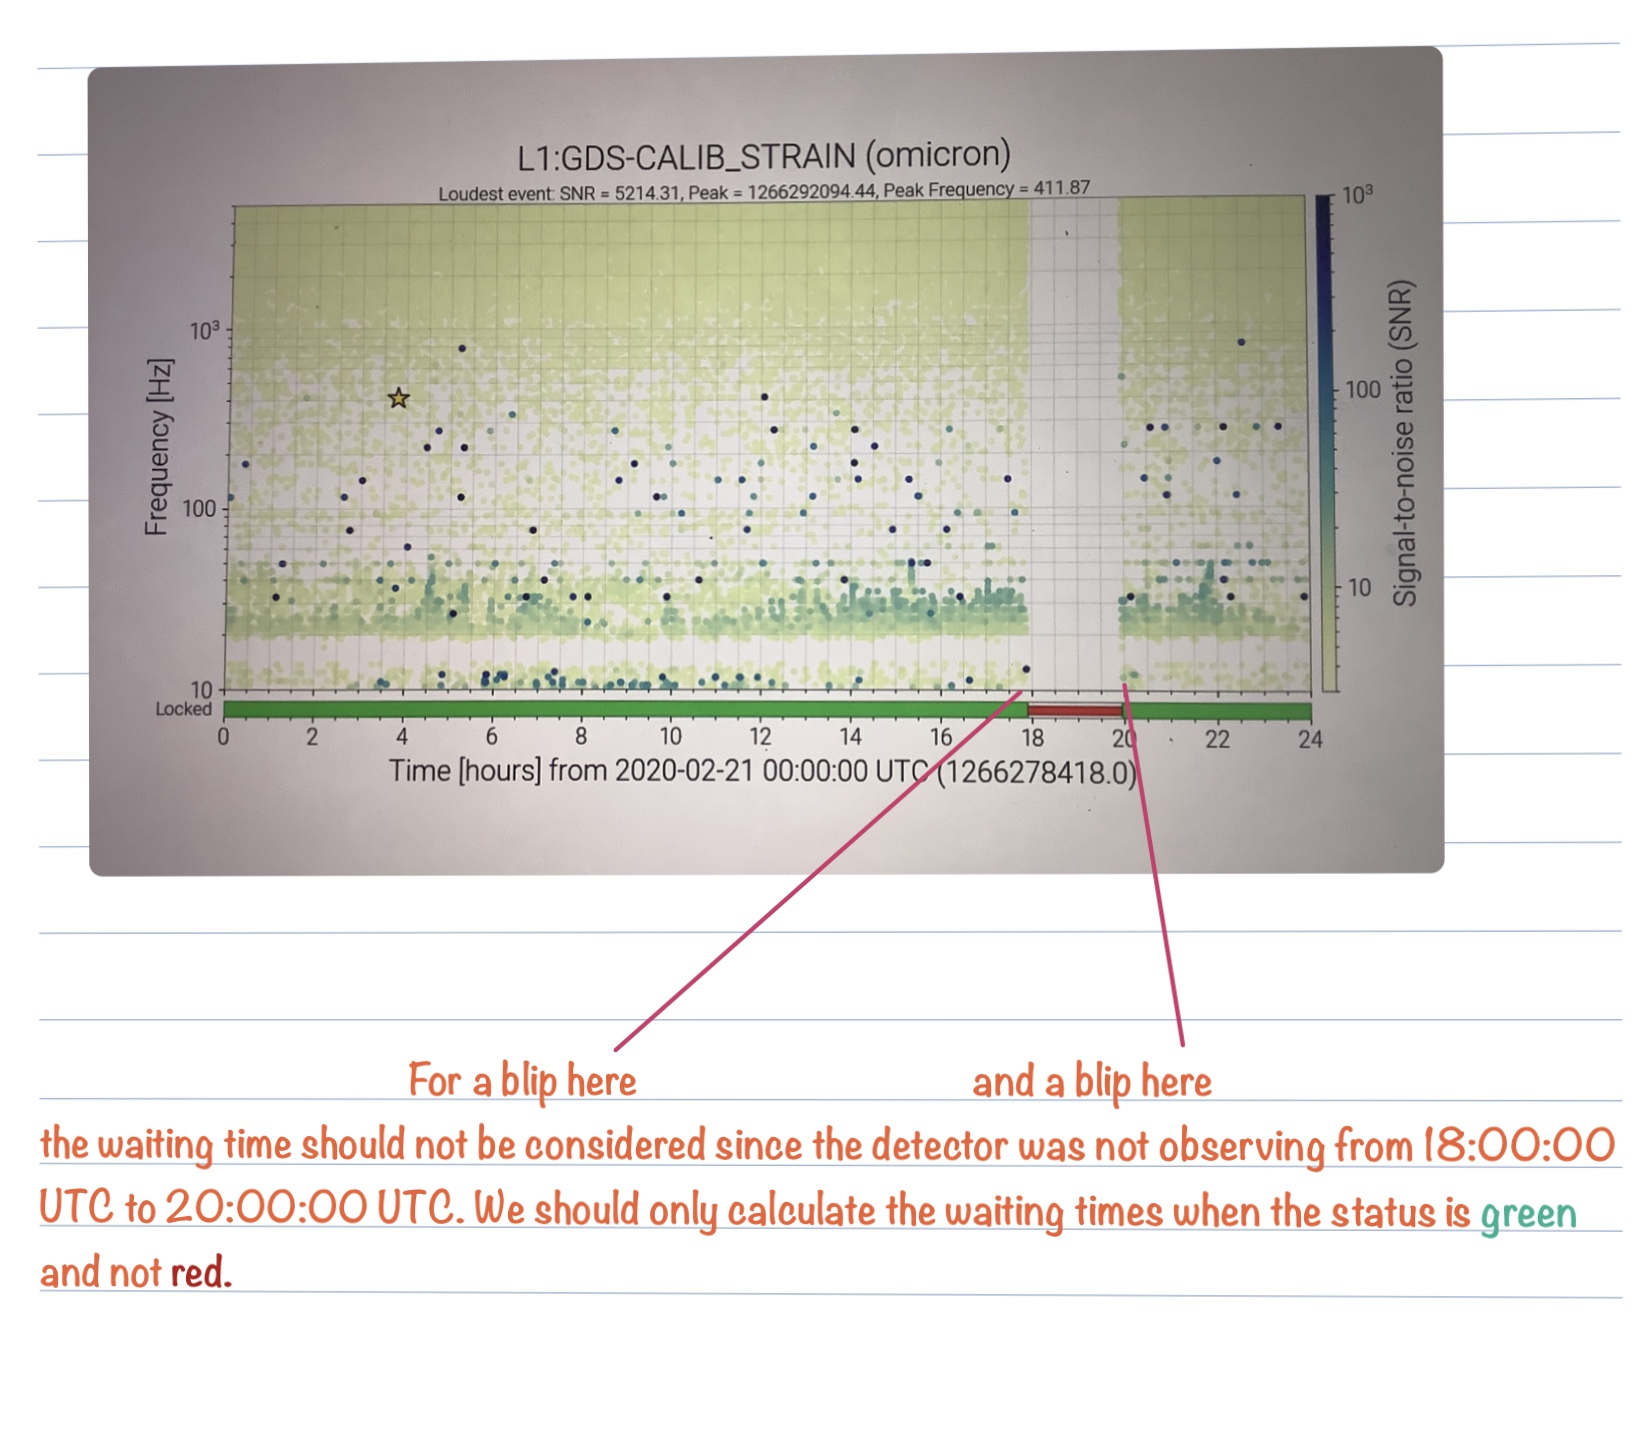

In [12]:
Image('locked.jpg')

### Active segments (green status for the detector) between Nov 20 and March 10

In [13]:
segs = SegmentList.read('segsforblips.txt')

In [14]:
blipsinsegs1 = [i for i in dfblips['GPStime'] for j in segs if i in j]

### In the code below, we first find all the blips which are within a continous lock segment and then we find the waiting times for all these blips, then we move on to other continous locked segments and repeat it. We do not find the time difference between blip glitches of two separate locked segments, since there is a lock loss between them. This is shown in the image below

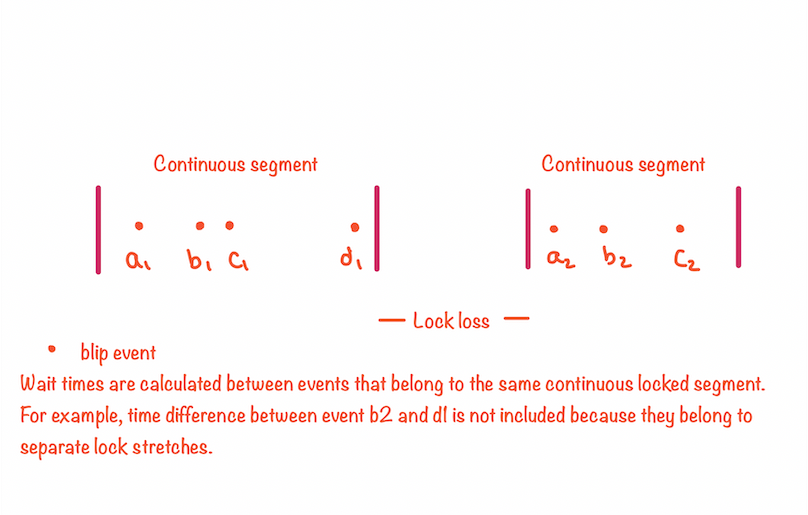

In [15]:
Image(filename='blips_jupyter.png')

In [16]:
tic=time.time()
waiting_times=[]
k=0
for i in segs:
    blipsinsegs=[]
    for j in dfblips['GPStime'][k:]:
        if j in i:
            k+=1
            blipsinsegs.append(j)
        else:
            pass
    if blipsinsegs:
        waiting_times.append(list(zip(np.diff(blipsinsegs),blipsinsegs)))
    else:
        waiting_times.append(list(zip([0],[0])))
#print(k)
wait_times = [i[0] for j in waiting_times for i in j] # making a flat list out of lists of list
wait_times = [i for i in wait_times if i!=0]  # excluding the 0's
toc = time.time()
print(toc-tic)

1.9401452541351318


### Lets now plot the wait times

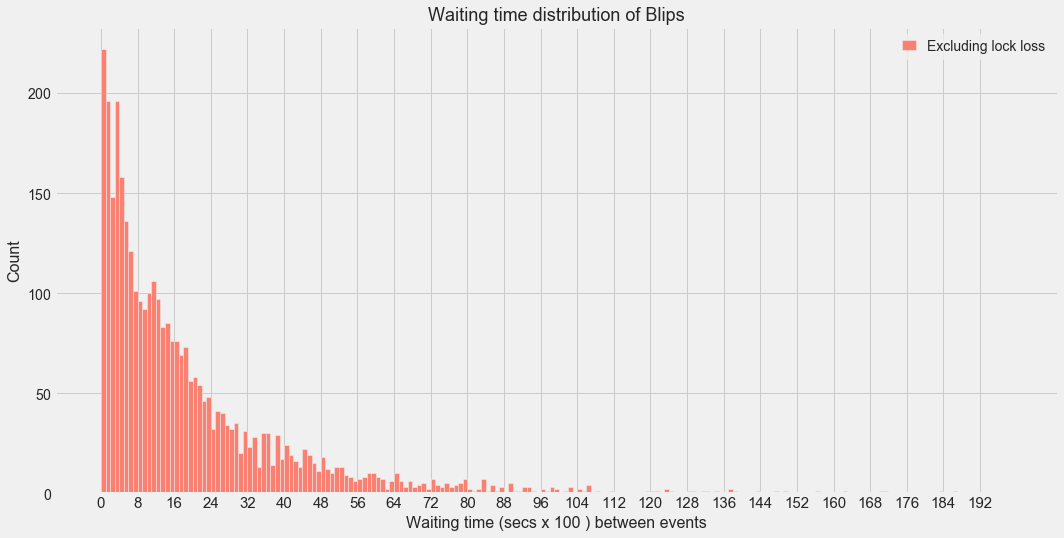

In [23]:
plt.figure(figsize=(16,8))
plt.hist(wait_times,bins=np.arange(0,20000,100),label='Excluding lock loss',color='salmon')
plt.xticks(np.arange(0,20000,800),np.arange(0,200,8),fontsize=15)
#plt.yscale('log')
plt.xlabel('Waiting time (secs x 100 ) between events',fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.title("Waiting time distribution of Blips",fontsize=18)
plt.legend()
plt.show()

### Average rate of Blip glitches per hour

In [18]:
### Total active duration
dur = int(np.sum([i.end-i.start for i in segs]))
dur

7675391

In [19]:
### Total number of blips during the active segments divided by total duration in hour
avg_rate = len(blipsinsegs1)*3600/dur
avg_rate

1.689451390815139

#### So on average we have 1.7 blips per hour

In [20]:
Prob = [np.exp(-avg_rate)*(avg_rate**i)/(math.factorial(i)) for i in range(0,20)]

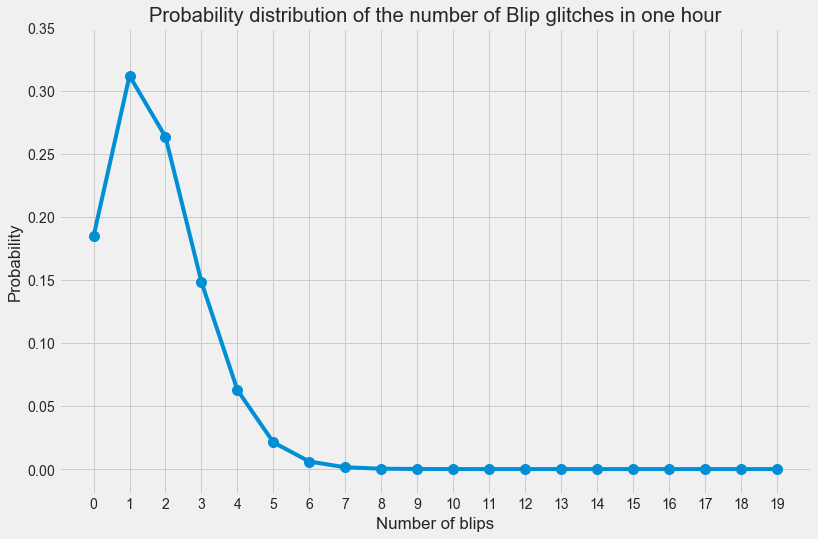

In [24]:
plt.figure(figsize=(12,8))
plt.plot(Prob,marker='o',markersize=10)
plt.ylim(-0.02,0.35)
plt.xticks(np.arange(0,20,1),np.arange(0,20,1))
plt.title("Probability distribution of the number of Blip glitches in one hour")
plt.xlabel("Number of blips")
plt.ylabel("Probability")
plt.show()